# Introduction

### Configuration

In [11]:
from pathlib import Path

# The cache directories:
cache_path       = '/data/crcns2021/hcpannot-cache'
image_cache_path = f'{cache_path}/annot-images'
v123_cache_path  = f'{cache_path}/annot-v123'
csulc_cache_path = f'{cache_path}/annot-csulc'
results_path = '/data/crcns2021/results'
contour_save_path = f'{results_path}/data_branch/save'
proc_path = f'{results_path}/proc'
traces_path = f'{proc_path}/traces'
paths_path = f'{proc_path}/paths'
labels_path = f'{proc_path}/labels'

hcpannot_lib_path = Path('~/hcp-annot-vc')
#If you aren't using /data
import os
os.environ['HCPANNOT_LOAD_PATH'] = cache_path

### Dependencies

In [12]:
import sys, pimms, pandas, warnings, urllib, datetime
import numpy as np
import scipy as sp
import scipy.sparse as sps
import nibabel as nib
import neuropythy as ny

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import ipyvolume as ipv
import torch, json

from collections import defaultdict

In [13]:
%matplotlib inline

In [14]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

### Import `hcpannot`

In [15]:
# Make sure we are in the right directory for this!

if hcpannot_lib_path:
    hlp = os.path.expandvars(os.fspath(hcpannot_lib_path))
    hlp = os.path.expanduser(hlp)
    if hlp.strip('/').endswith('hcpannot'):
        warnings.warn(
            "adding hcpannot_lib_path that ends with 'hcpannot';"
            " the hcpannot_lib_path should contain the hcpannot directory")
    if os.path.isdir(hlp):
        sys.path.append(hlp)
    else:
        raise ValueError("hcpannot_lib_path is not a directory")
# We try importing it and if we fail, we check to see if we are just running
# the notebook from the work directory and try again.
try:
    import hcpannot
except ModuleNotFoundError:
    hcpannot = None
    if os.getcwd().endswith('/work'):
        hlp = os.path.abspath('..')
        sys.path.append(hlp)

# Note the cache path we want to use outside the docker container;
# normally this gets set by the Docker startup, so here outside
# the docker container we set it manually.
hcpannot.interface.default_load_path = cache_path
# We have to update some data after setting this.

# We also want to grab a few variables from hcpannot:
from hcpannot.interface import default_imshape as roi_image_shape
roi_image_shape = roi_image_shape[0] // 2
from hcpannot.interface import imgrid_to_flatmap
from hcpannot.interface import flatmap_to_imgrid
# The proc (for processing contours):
from hcpannot.proc import proc, meanproc
# The functions for loading and saving contours.
from hcpannot import (save_contours, load_contours)

# Subject lists. These are defined in the analysis subpackage of
# the hcpannot library, and subject_list_<x> is the <x>th list of
# subject IDs that we assigned.

### POTENTIAL ISSUE WITH
from hcpannot import subject_list
sids = np.array(hcpannot.subject_list)


# The mean rater's name ('mean') and some plotting functions are also defined in
# the hcpannot.analysis subpackage.
from hcpannot.analysis import meanrater #plot_vc_contours)

#Finally, we have some multiprocessing tools.
# from hcpannot.mp import (tupcall, okaystr, failstr, retry_sleep, mprun, mpstep,
#                          makejobs)

from hcpannot.proc import proc, meanproc

### Usage Notes

Here's an example code-block using the `plot_contours` function to plot a set of boundaries along with the V1-V3 contours.

```python
dat = proc('ventral', rater='BrendaQiu',
              sid=111312,
              hemisphere='lh',
              save_path=proc_path,
              load_path=contour_save_path)
# Make the flatmap plot and the boundaries.
fig = plot_contours(dat, boundaries=True)
# Extract the pyplot axes that were used.
ax = fig.axes[0]
# Grab the subject data, which includes the V1-V3 contours.
sdat = hcpannot.interface.subject_data[(dat['sid'],dat['hemisphere'])]
# And plot all of these contours:
for (x,y) in sdat['v123'].values():
    ax.plot(x, y, 'w-', lw=0.25)
```

## Work

### Average across raters

In [16]:
sids = ny.data['hcp_lines'].subject_list
raters = ['BrendaQiu', 'JiyeongHa', 'bogengsong', 'lindazelinzhao', 'nourahboujaber', 'jennifertepan']
rater_plot_colors = {
    'BrendaQiu':'r',
    'JiyeongHa':'g',
    'bogengsong':'b',
    'lindazelinzhao':'c',
    'nourahboujaber':'m',
    'jennifertepan':'y',
    'mean':'k'}

In [17]:
def plot_contours(raters, subject_id, hemi, roi,
                  plot_average=True,
                  plot_individuals=True,
                  plot_figure=True,
                  plot_colors=rater_plot_colors,
                  axes=None,
                  lw=None,
                  npoints = 500):
    
    load_ind = plot_individuals
    coordinates = {}

    # get path of mean cache file
    if plot_average:
        
        r = 'mean'
        cache_file = os.path.join(proc_path, 'fsaverage', f"cacherater_{r}_{subject_id}_{hemi}_{roi}.mgz")
            
        # check if they have an existing cache file, if so load the coordinates of the contour directly
        if os.path.isfile(cache_file):
            coordinates[r] = ny.load(cache_file)

        # otherwise, find the contour through vc_plan
        else: 
            try:
                dat = meanproc('ventral', sid=subject_id, hemisphere=hemi, save_path=proc_path, load_path=contour_save_path)
                trace = dat['traces'][roi]
                # coordinates are defined by deault as 500 evenly spaced points along the trace curve 
                coordinates[r] = trace.curve.linspace(npoints)

                cortex = dat['cortex']
                fmap1 = dat['flatmap']
                fmap2 = ny.to_flatmap('occipital_pole', cortex)
                addr = fmap1.address(coordinates[r])
                coordinates[r] = fmap2.unaddress(addr)

                ny.save(cache_file, coordinates[r])
            
            except Exception as e:
                print(e)
   
    # load individual contours
    if load_ind:
        vcplans = {}
        
        # for each rater in the rater list
            
        for r in raters:
            cache_file = os.path.join(proc_path, 'fsaverage', f"cacherater_{r}_{subject_id}_{hemi}_{roi}.mgz")
            
            # check if they have an existing cache file, if so load the coordinates of the contour directly
            if os.path.isfile(cache_file):
                coordinates[r] = ny.load(cache_file)
            # otherwise, find the contour through vc_plan
            else:
                try:
                    dat = proc('ventral',rater=r, sid=subject_id, hemisphere=hemi, save_path=proc_path, load_path=contour_save_path)
                    vcplans[r] = dat
                    trace = dat['traces'][roi]
                    
                    # coordinates are defined as 500 evenly spaced points along the trace curve 
                    coordinates[r] = trace.curve.linspace(500)
                    
                    cortex = dat['cortex']
                    fmap1 = dat['flatmap']
                    fmap2 = ny.to_flatmap('occipital_pole', cortex)
                    addr = fmap1.address(coordinates[r])
                    coordinates[r] = fmap2.unaddress(addr)
                    
                    # save the coordinates
                    ny.save(cache_file, coordinates[r])
                    
                # handle exceptions of missing contours
                except Exception as e:
                    print(e)
          
    # Make the plots:   
    if plot_figure == True:
        
        # If axes is not specified, get the current axes.
        if axes is None:
            axes = plt.gca()

        for (k, (x,y)) in coordinates.items():
            c = plot_colors.get(k, 'gray')
            axes.plot(x, y, '-', color=c, lw=lw, label=k) 
            
        # plot the legends
        axes.legend()
    
    # print message
    print (subject_id, hemi, 'finished')

In [9]:
# generate cache files
for sid in sids[140:160]:
    for hemi in ['lh', 'rh']:
        plot_contours(raters, sid, hemi, 'VO1_VO2', plot_figure=False)

115017 lh finished
115017 rh finished
load_contours [jennifertepan/134829/lh] file not found for hV4_VO1: /data/crcns2021/results/data_branch/save/jennifertepan/134829/lh.hV4_VO1.json
134829 lh finished
load_contours [jennifertepan/134829/rh] file not found for hV4_VO1: /data/crcns2021/results/data_branch/save/jennifertepan/134829/rh.hV4_VO1.json
134829 rh finished
load_contours [jennifertepan/156334/lh] file not found for hV4_VO1: /data/crcns2021/results/data_branch/save/jennifertepan/156334/lh.hV4_VO1.json
156334 lh finished
load_contours [jennifertepan/156334/rh] file not found for hV4_VO1: /data/crcns2021/results/data_branch/save/jennifertepan/156334/rh.hV4_VO1.json
156334 rh finished
load_contours [jennifertepan/169444/lh] file not found for hV4_VO1: /data/crcns2021/results/data_branch/save/jennifertepan/169444/lh.hV4_VO1.json
169444 lh finished
load_contours [jennifertepan/169444/rh] file not found for hV4_VO1: /data/crcns2021/results/data_branch/save/jennifertepan/169444/rh.hV4_

In [19]:
roi_colors = {'hV4': 'r',
              'VO1': 'g',
              'VO2': 'b'}

def create_LineCollection(sids, hemi, roi, 
                          path=contour_save_path, 
                          color=None):
    
    sid_plotted = []
    lines = [] 
    
    for sid in sids:
        mean_cache_file = os.path.join(proc_path, 'fsaverage', f"cacherater_mean_{sid}_{hemi}_{roi}.mgz")
        if os.path.isfile(mean_cache_file):
            sid_plotted.append(sid)
            mean_coord = ny.load(mean_cache_file)
            mean_coord = np.column_stack(mean_coord)
            lines.append(mean_coord)
    lc = LineCollection(lines, linewidths=0.2, alpha = 0.2, colors = color)
    sid_missing = [s for s in sids if s not in sid_plotted]
    return (sid_missing, lc)

def plot_averages(sids, hemi, roi,
                      path=contour_save_path,
                      ax=None,
                      colors=None):  
    
    if ax == None:
        (fig, ax) = plt.subplots(1,1, figsize=(5,3), dpi=72*8)

    if isinstance(roi, list):
        for k in roi:
            (sid_missing, lc) = create_LineCollection(sids, hemi, k, path, color=roi_colors.get(k, 'gray'))
            ax.add_collection(lc)
            num_missing = len(sid_missing)
            print(f'{hemi}, {k}, {num_missing} subjects not plotted', sid_missing)
        ax.set_title(' '.join(roi))
    else:
        (sid_missing, lc) = create_LineCollection(sids, hemi, roi, path, color=roi_colors.get(roi, 'gray'))
        ax.add_collection(lc)
        num_missing = len(sid_missing)
        print(f'{hemi}, {k}, {num_missing} subjects not plotted')
        ax.set_title(roi)
   
    ax.set_xlim(-60, 60)
    ax.set_ylim(-100, 20)
    

lh, hV4, 0 subjects not plotted []
lh, VO1, 0 subjects not plotted []
lh, VO2, 0 subjects not plotted []
rh, hV4, 0 subjects not plotted []
rh, VO1, 0 subjects not plotted []
rh, VO2, 0 subjects not plotted []


/home/brendaqiu/.conda/envs/cnn/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/brendaqiu/.conda/envs/cnn/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


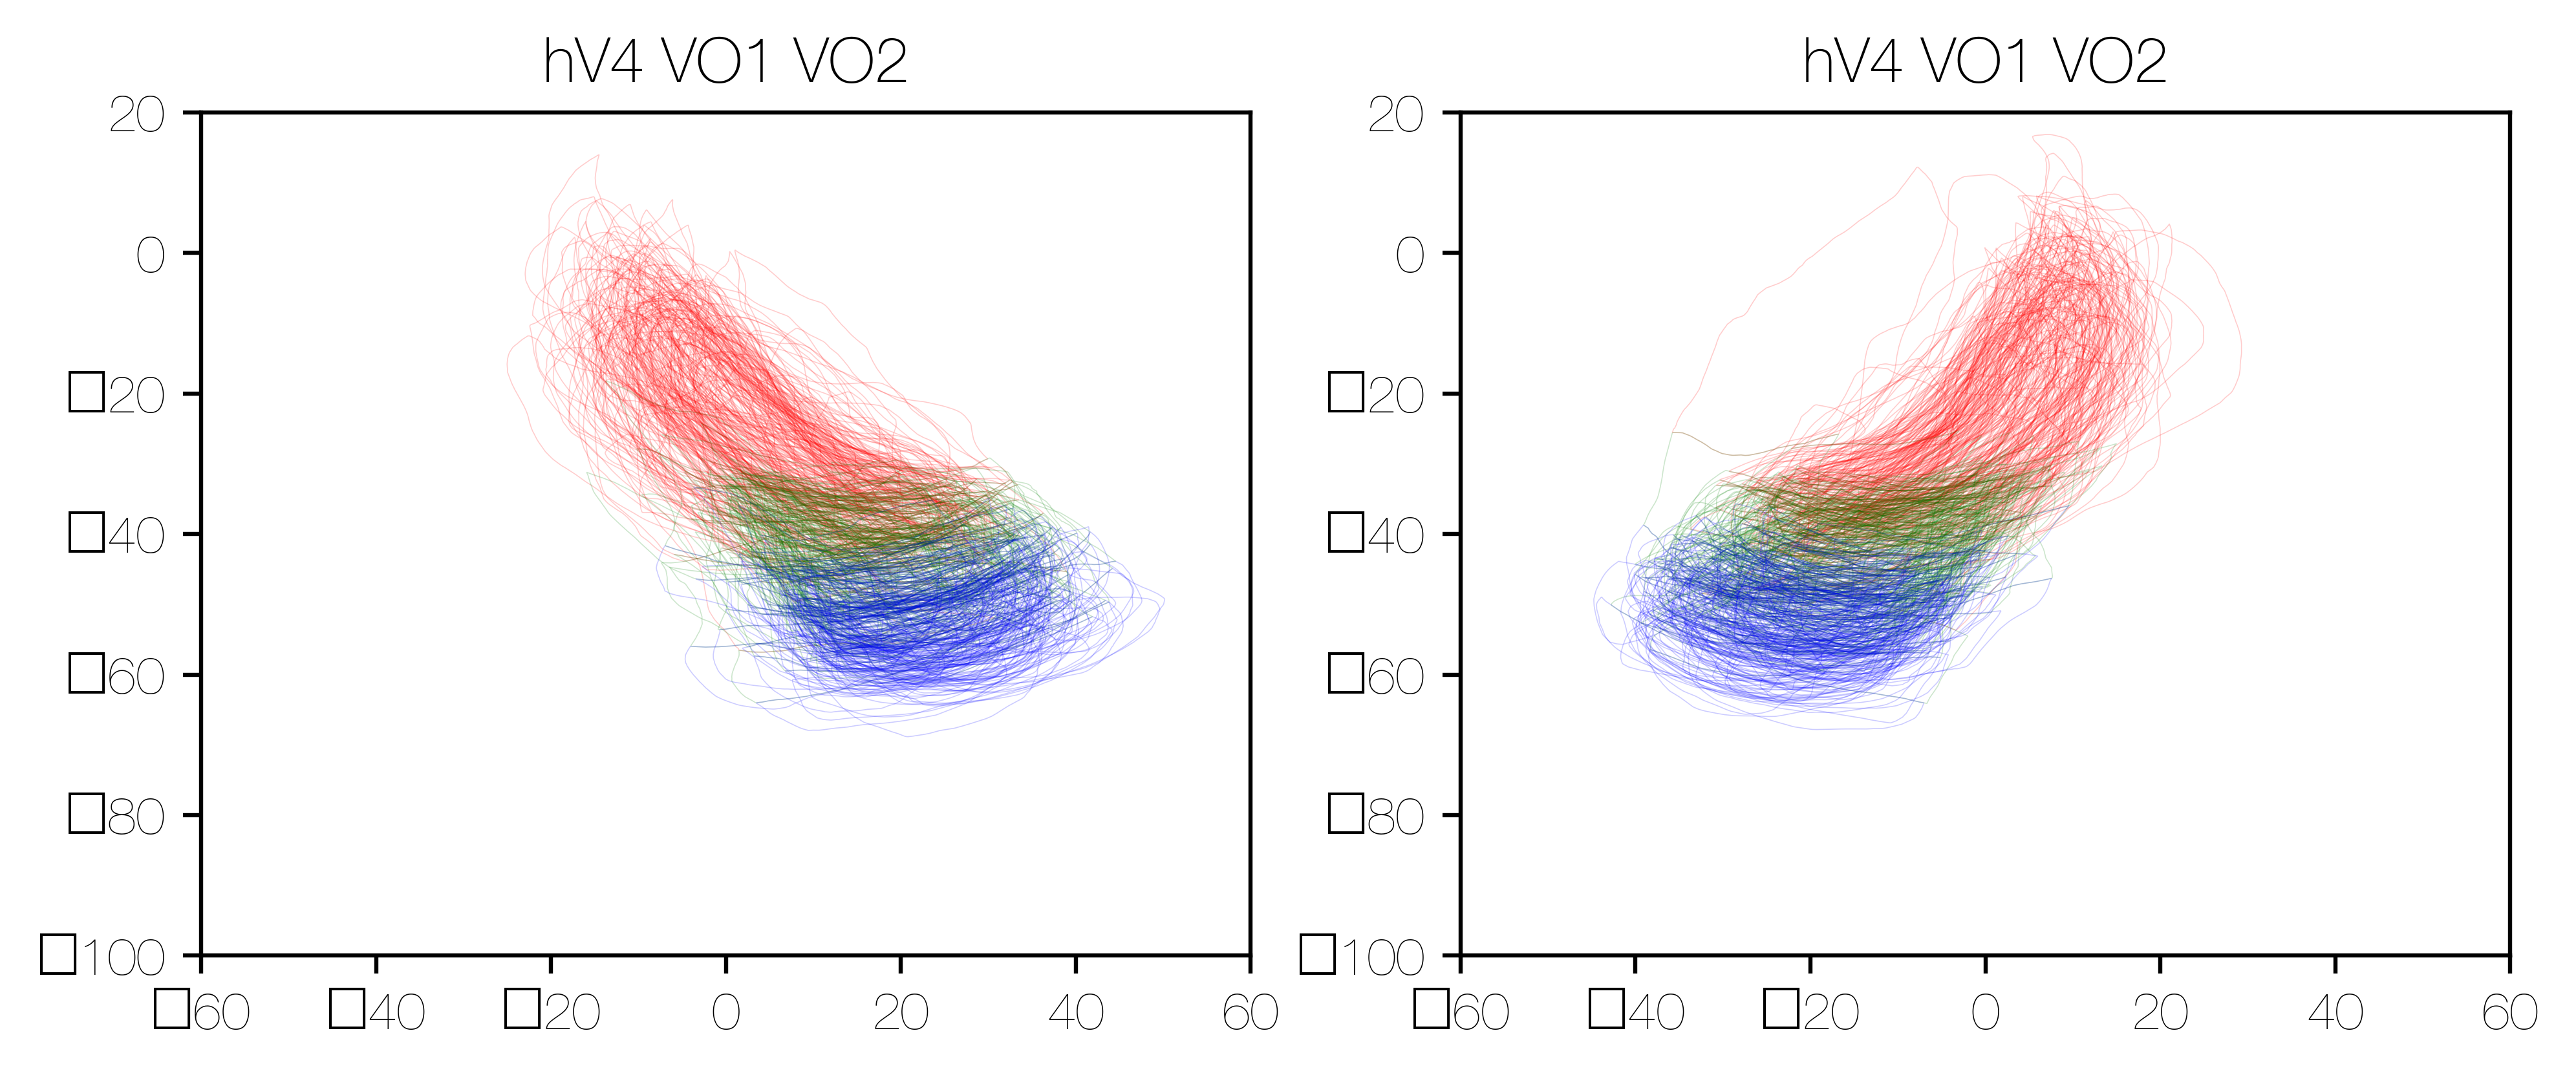

In [20]:
(fig,axes) = plt.subplots (1,2, figsize=(8,3), dpi=72*8)
plot_averages(sids, 'lh', ['hV4','VO1','VO2'], ax=axes[0], colors=roi_colors)
plot_averages(sids, 'rh', ['hV4','VO1','VO2'], ax=axes[1], colors=roi_colors)

In [25]:
#contours_std = ['hV4_VO1', 'VO1_VO2', 'hV4_outer', 'VO_outer']
contours_std = ['hV4_outer', 'VO_outer', 'hV4_VO1']

def nestget(d, k):
    """Retrieves nested data from the proc dictionaries.
    
    Certain keys such as `'boundaries'` are accessible in the dictionaries that
    are returned by the `proc` function only via the `'nested_data'` key, which
    typically contains another proc dictionary with additional data. The
    `nestget` function gets data from these embedded dictionaries.
    """
    while k not in d:
        d = d['nested_data']
    return d[k]

def contour_std(hemi, npoints=500):
    
    all_contours = defaultdict(lambda:[])
    
    for subject_id in sids:
        for name in contours_std:
            try:
                file = os.path.join(proc_path, 'fsaverage', f"cacherater_mean_{subject_id}_{hemi}_{name}.mgz")
                coords = ny.load(file)
                all_contours[name].append(coords)
            except Exception as e:
                print(e)
                
        # add V3v       
        data = meanproc('ventral', sid=subject_id, hemisphere=hemi, save_path=proc_path, load_path=contour_save_path)
        v3v_contour = nestget(data, 'v3v_contour')
        v3v_curve = ny.curve_spline(v3v_contour[0], v3v_contour[1])
        all_contours['V3v'].append(v3v_curve.linspace(npoints))
        
    result = {}
    
    for name in contours_std + ['V3v']:
        contour_mean = np.mean(all_contours[name], axis=0)
        contour_dist = np.sqrt(np.sum((all_contours[name]-contour_mean)**2, axis=1))
        result[name] = np.std(contour_dist, axis=0)

    return (all_contours, result)
    

In [26]:
(all_contours_lh, result_lh) = contour_std('lh')
(all_contours_rh, result_rh) = contour_std('rh')

Text(0.5, 1.0, 'rh')

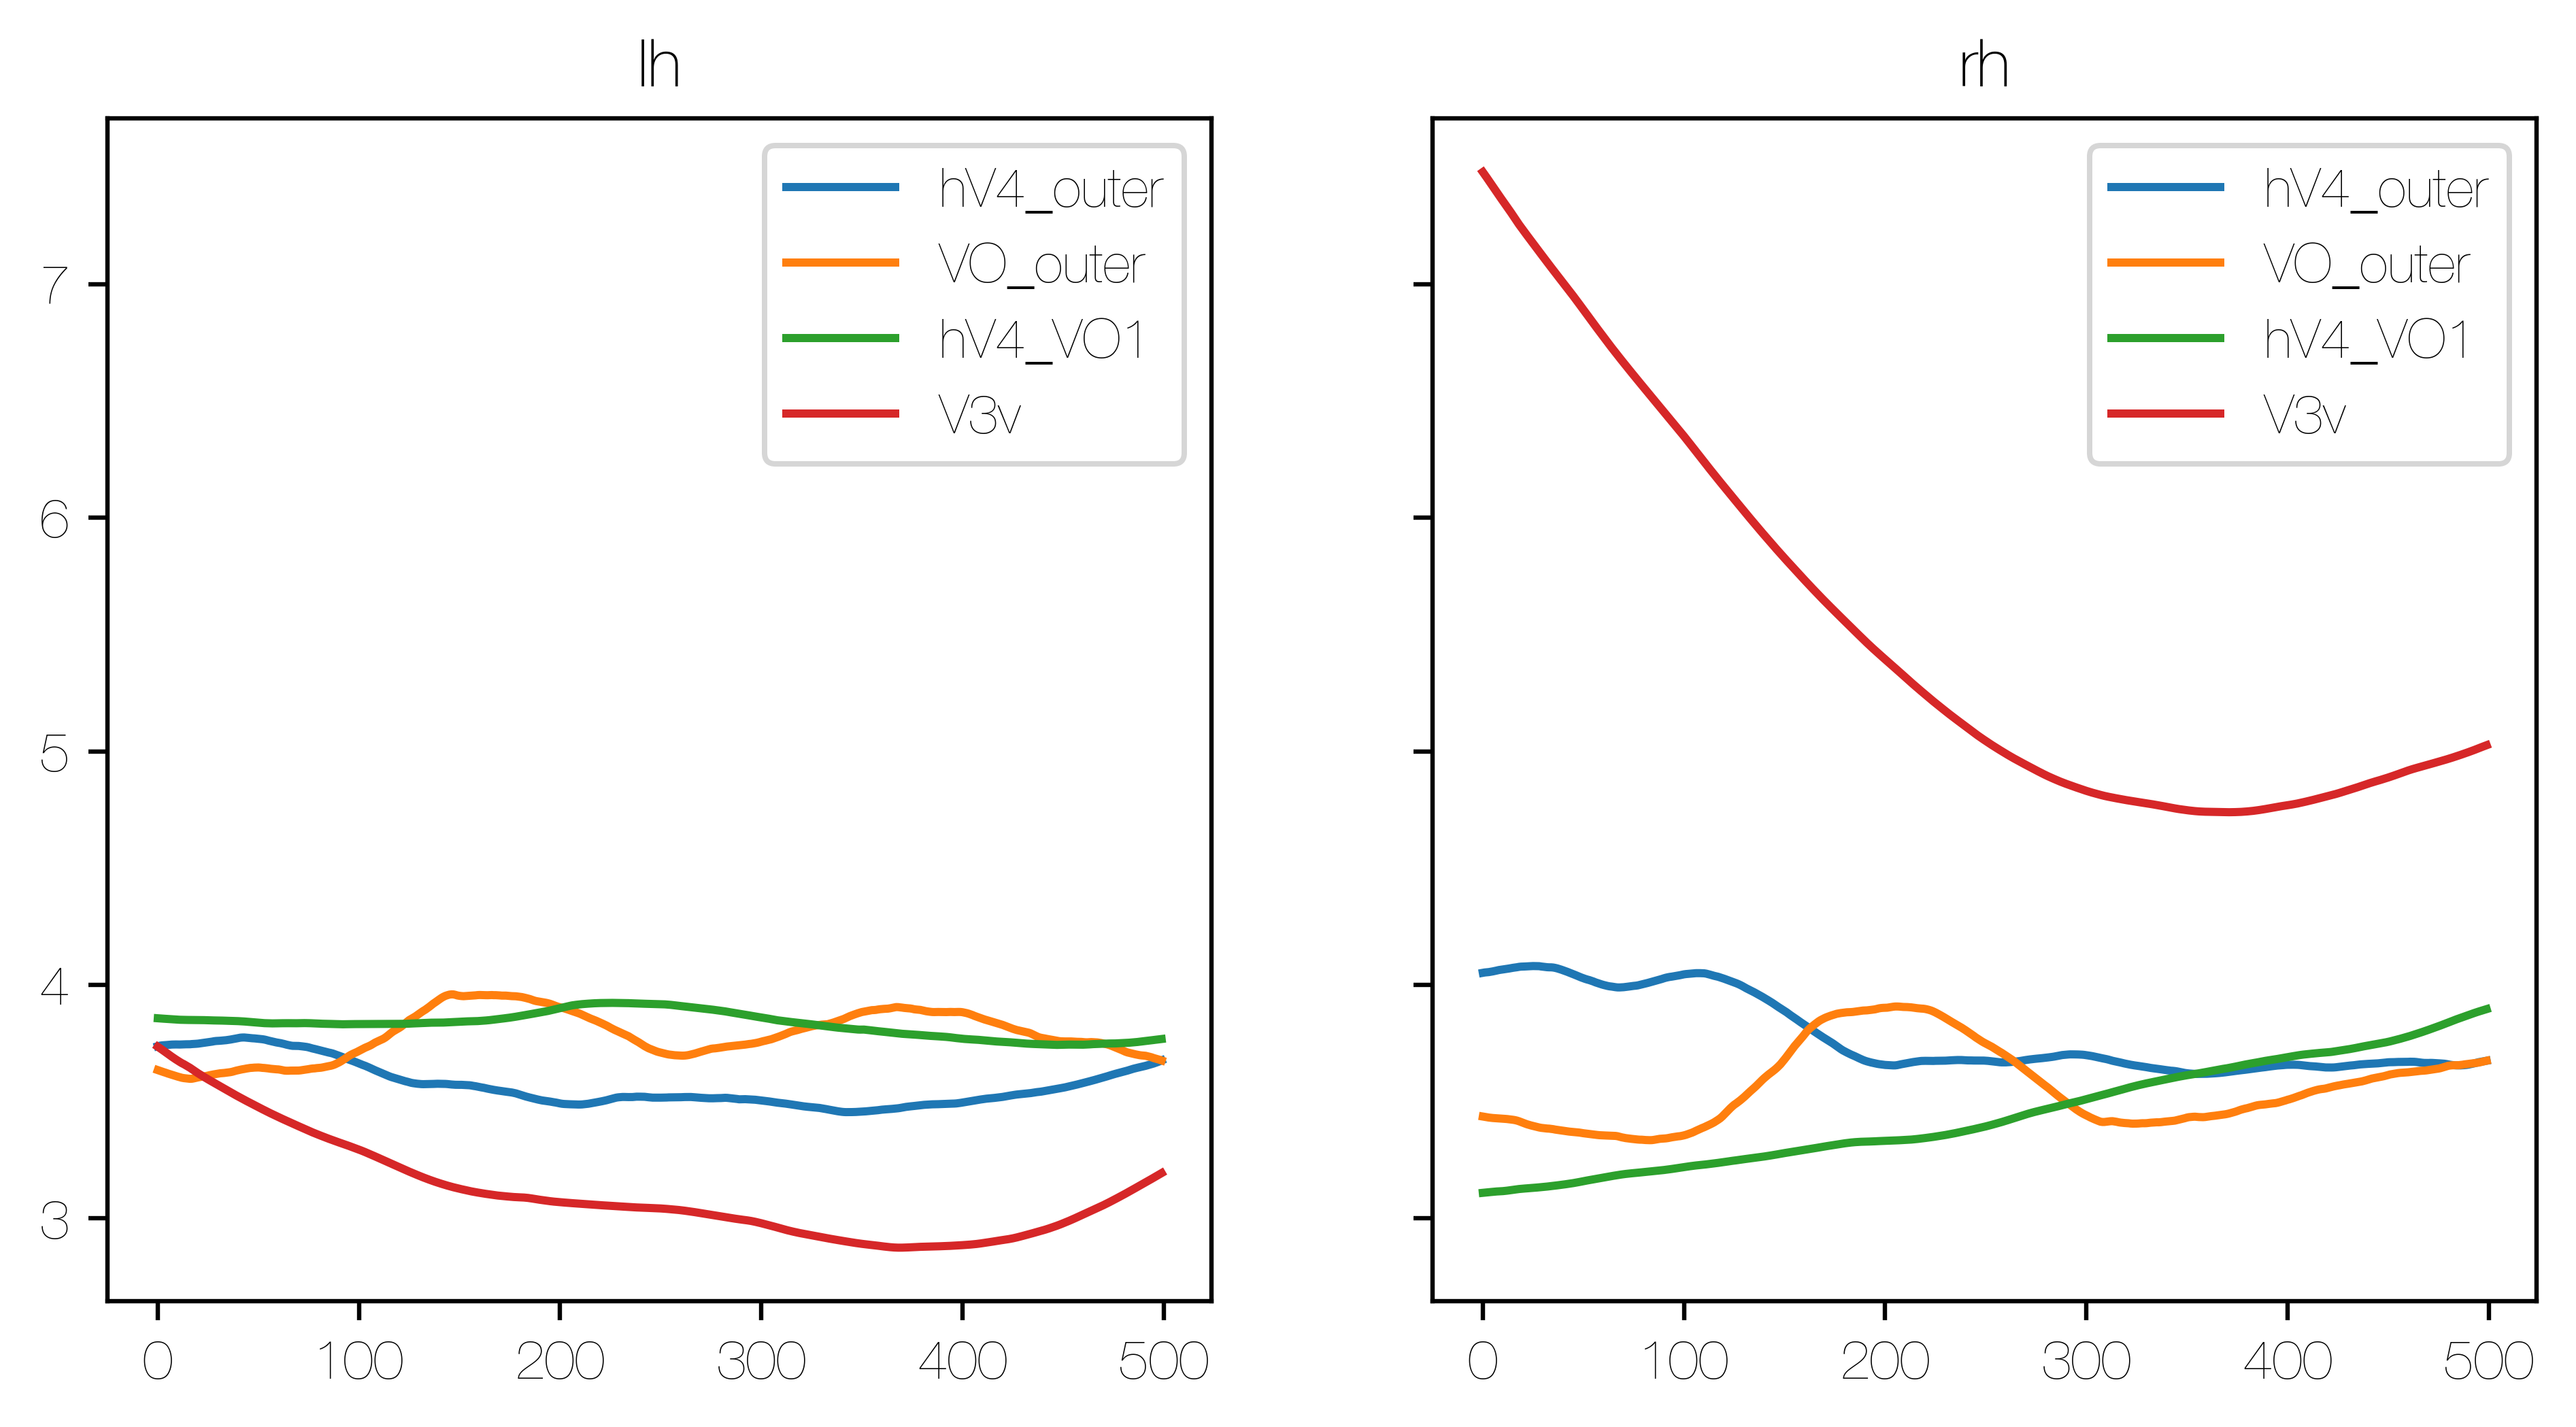

In [27]:
(fig,ax) = plt.subplots(1, 2, figsize=(8,4), dpi=72*8, sharey=True)

for (i,result) in enumerate([result_lh, result_rh]):
    for k,x in result.items():
        ax[i].plot(range(500), x, '-', label=f'{k}')
        #ax[i].plot(range(500), y, '-', label=f'{k}_y')
        ax[i].legend()
ax[0].set_title('lh')
ax[1].set_title('rh')

In [28]:
def plot_startend(all_contours_lh, all_contours_rh, contour):
    
    (fig,ax) = plt.subplots(2, 2, figsize = (8,3), dpi=72*8)
    
    for (i,all_contours) in enumerate([all_contours_lh, all_contours_rh]):
        
        coords = all_contours[contour]
        x1_values = []
        x2_values = []
        y1_values = []
        y2_values = []

        for j in range(np.shape(coords)[0]): # 181 subjects
            x1_values.append(coords[j][0][0])
            x2_values.append(coords[j][0][499])
            y1_values.append(coords[j][1][0])
            y2_values.append(coords[j][1][499])

        ax[0,i].plot(x1_values, label = 'x_start')
        ax[0,i].plot(x2_values, label = 'x_end')
        ax[0,i].legend()
        ax[1,i].plot(y1_values, label = 'y_start')
        ax[1,i].plot(y2_values, label = 'y_end')
        ax[1,i].legend()
   
    ax[0,0].set_title('lh')
    ax[0,1].set_title('rh')


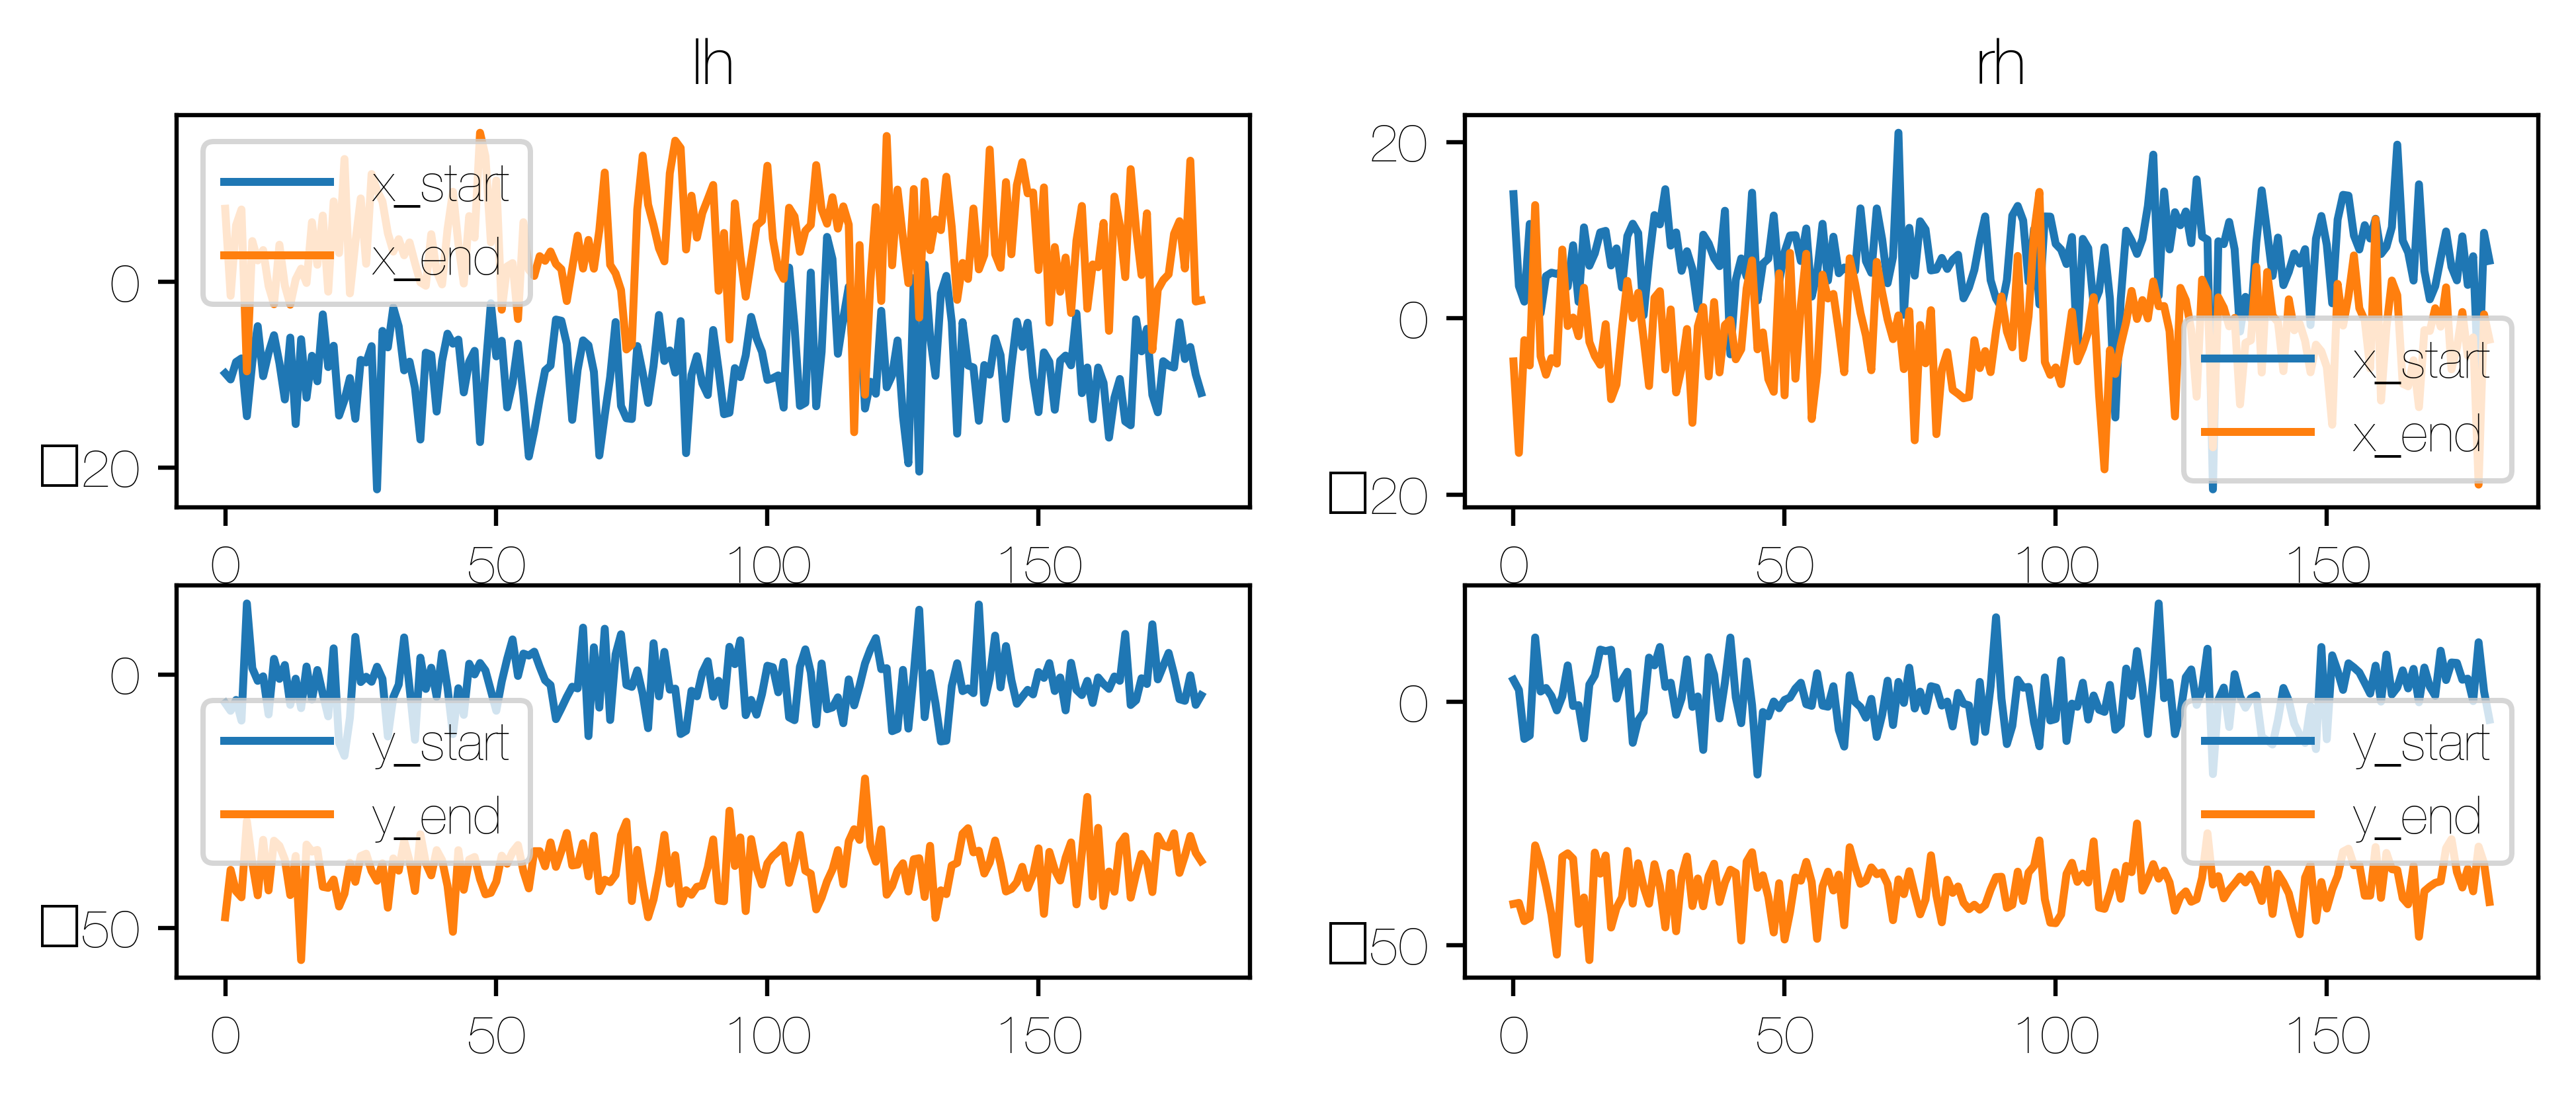

In [29]:
plot_startend(all_contours_lh, all_contours_rh, 'hV4_outer')

In [30]:
colors = dict(zip(all_contours_lh.keys(), ['lightblue', 'lightgreen', 'orange', 'yellow', 'lightpink']))

def plot_errorbar(all_contours, result, contour, ax, scale=True):
    
    contours = all_contours[contour][0]
    x_coords = contours[0]
    y_coords = contours[1]
    ax.plot(x_coords, y_coords, 'k-', alpha = 0.5)
    
    x_sd = result[contour][0]
    y_sd = result[contour][1]
    
    if scale==True:
        scalar = 1/3
    else:
        scalar = 1
        
    for i in range(np.shape(x_coords)[0]):
        x_curve = np.array([x_coords[i] - x_sd[i]*scalar, x_coords[i] + x_sd[i]*scalar])
        y_curve1 = np.array([y_coords[i] - y_sd[i]*scalar, y_coords[i] - y_sd[i]*scalar])
        y_curve2 = np.array([y_coords[i] + y_sd[i]*scalar, y_coords[i] + y_sd[i]*scalar])
        
        ax.fill_between(x_curve, y_curve1, y_curve2, color = colors[contour], alpha=0.1)

IndexError: invalid index to scalar variable.

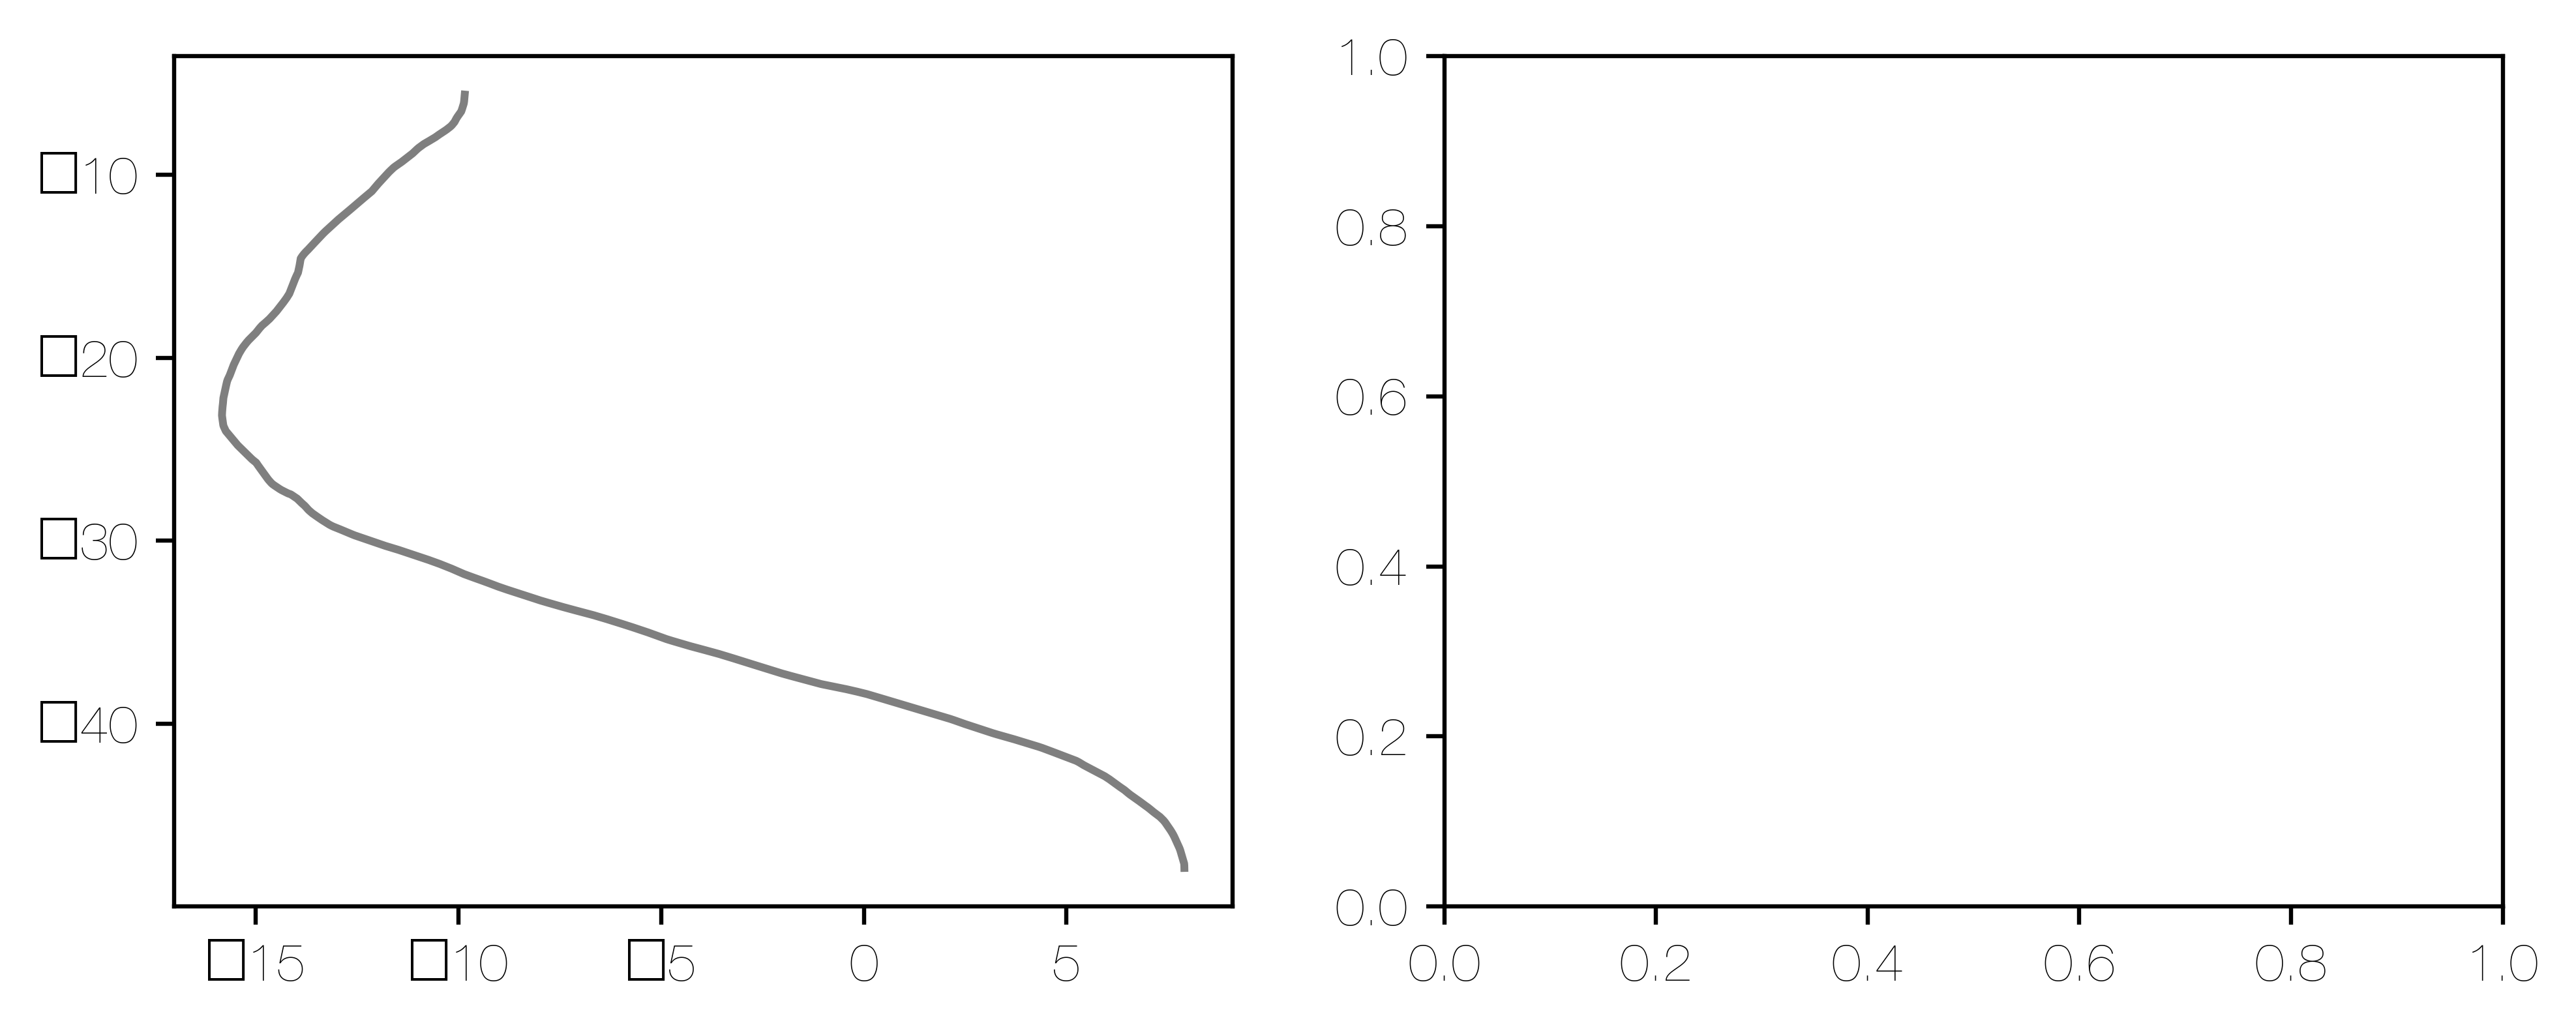

In [31]:
(fig,ax) = plt.subplots(1, 2, figsize = (8,3), dpi = 72*8)
for contour in all_contours_lh.keys():
    plot_errorbar(all_contours_lh, result_lh, contour, ax = ax[0])
    plot_errorbar(all_contours_rh, result_rh, contour, ax = ax[1])

In [ ]:
# Check specific contour
rater = 'nourahboujaber'
sid = 100610
hemi = 'rh'
colors = {'hV4': [1,0,0], 'VO1': [0,1,0], 'VO2': [0,0,1]}

data = vc_plan(
    rater=rater,
    sid=sid,
    hemisphere=hemi,
    save_path=trace_save_path)

# fig = plot_contours(data, boundaries=True)
(fig, ax) = plt.subplots(1,1, figsize=(5,3), dpi=72*8)
for (name, (x, y)) in data['boundaries'].items():
    ax.plot(x,y,'r-'
# Grab the subject data, which includes the V1-V3 contours.
sdat = hcpannot.interface.subject_data[(data['sid'], data['hemisphere'])]
# And plot all of these contours:
ax = fig.axes[0]
for (x,y) in sdat['v123'].values():
    ax.plot(x, y, 'w-', lw=0.25)

pass -->

In [ ]:
# First: Average across two subjects for the same rater.

# Get the traces for one rater and one subject.
dat1 = vc_plan(
    rater=rater1,
    sid=sid1,
    hemisphere='lh',
    save_path=trace_save_path)
dat2 = vc_plan(
    rater=rater1,
    sid=sid2,
    hemisphere='lh',
    save_path=trace_save_path)

In [ ]:
# To average across subjects for a single rater, we need to warp everything
# into the fsaverage so that subject surfaces are aligned.
# To do this we need to make path objects from the trace objects.

# Grab a trace:
trace1 = dat1['traces']['hV4']
# Get the subject's hemisphere data:
hem1 = ny.data['hcp_lines'].subjects[sid1].hemis['lh']

# Turning the trace into a path (which knows about how the trace intersects
# the triangles in the mesh, so we can warp the trace/path into fsaverage
# alignment).
path1 = trace1.to_path(hem1)
# Make an fsaverage-aligned flatmap:
fmap1 = ny.to_flatmap('occipital_pole', hem1)
# Extract x and y coordinates in fsaverage-aligned flatmap.
fsa_coords1 = fmap1.unaddress(path1.addresses)

# Do the same thing for the other trace:
trace2 = dat2['traces']['hV4']
# Get the subject's hemisphere data:
hem2 = ny.data['hcp_lines'].subjects[sid2].hemis['lh']

# Turning the trace into a path (which knows about how the trace intersects
# the triangles in the mesh, so we can warp the trace/path into fsaverage
# alignment).
path2 = trace2.to_path(hem2)
# Make an fsaverage-aligned flatmap:
fmap2 = ny.to_flatmap('occipital_pole', hem2)
# Extract x and y coordinates in fsaverage-aligned flatmap.
fsa_coords2 = fmap2.unaddress(path2.addresses)

In [ ]:
# Plot the two subjects' traces together:
(x, y) = fsa_coords1
plt.plot(x, y, 'k.-')
(x, y) = fsa_coords2
plt.plot(x, y, 'r.-')

In [ ]:
# Average the traces of the subjects together:
curve1 = ny.util.CurveSpline(fsa_coords1)
fsa_normalized_coords1 = curve1.linspace(800)
curve2 = ny.util.CurveSpline(fsa_coords2)
fsa_normalized_coords2 = curve2.linspace(800)

fsa_coords_avg = 0.5 * (fsa_normalized_coords1 + fsa_normalized_coords2)

In [ ]:
(x, y) = fsa_coords1
plt.plot(x, y, 'b.-')
(x, y) = fsa_coords2
plt.plot(x, y, 'r.-')
# Add in the average coordinate.
(x, y) = fsa_coords_avg
plt.plot(x, y, 'k.-')

In [ ]:
# Once you've calculated a set of fsaverage-aligned points, you can save it to
# disk and reload it.
ny.save(f'{sid1}_{rater1}_fsacoords.mgz', fsa_normalized_coords1)

In [ ]:
ny.load(f'{sid1}_{rater1}_fsacoords.mgz')

In [ ]:
# Extract traces for hV4 boundary and split them into 500 evenly-spaced
# points along the boundary.
trace1 = dat1['traces']['hV4'] #'hV4' here can be replaced with 'VO1' or 'VO2'
coords1 = trace1.curve.linspace(500)
trace2 = dat2['traces']['hV4']
coords2 = trace2.curve.linspace(500)

# Now we just average the two coordinate sets.
coords_avg = 0.5 * (coords1 + coords2)

# Plot the average (along with the originals in blue and red).
for (color, (x,y)) in zip(['r', 'b', 'k'], [coords1, coords2, coords_avg]):
    plt.plot(x, y, color + '-')